In [1]:
import numpy as np 
import pandas as pd
#import plotly.plotly as py
#from plotly.offline import init_notebook_mode,iplot
#init_notebook_mode(connected=True)
import plotly.graph_objs as go
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
#%matplotlib inline
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score,roc_curve,make_scorer
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import os
import scikitplot as skplt
import seaborn as sns
import time

In [2]:
data=pd.read_csv('remotelist_tokens.csv')

In [3]:
data.shape

(5489, 6)

In [4]:
data.head(2)

,id,text,mes_date,views,mes_title,mes_description
0,42,новые вакансии за последние 2 часа,2018-03-09 20:37:02+00:00,133.0,новые вакансии за последние 2 часа,последние 2 часа опубликовано 5 вакансий block...
1,43,новые вакансии за последние 2 часа,2018-03-09 22:37:07+00:00,153.0,новые вакансии за последние 2 часа,последние 2 часа опубликовано 3 вакансий remot...


In [5]:
dict_target = {'BACKEND':  ['разработчик','developer','engineer','python','software engineer','software development','nodejs developer','python developer','python engineer','backend',
        'back-end','back end', 'full stack', 'fullstack','full-stack', 'ruby on rails', 'ruby', 'java', 'java-', 'php', 'django',
        'golang', 'drupal', 'wordpress', 'web developer', 'c++', 'c#'],
        'FRONTEND': ['frontend', 'front-end','front end', 'vue', 'react','ember', 'backbone','javascript', 'html'], 
        'MOBILE':['mobile','android','ios','mobile engineer', 'mobile developer', 'unity'], 
        'QA':['qa engineer','тестировщик','тестирование','tester'],
        'DEVOPS': ['devops', 'sysops','linux'], 
        'DATAOPS': ['data engineer'], 
        'DATA SCIENCE': ['data', 'data scientist', 'machine learning', 'analyst', 'аналитик'],
        'MARKETING':['marketer','marketing','маркетинг'],'DESIGN':['design','ui/ux', 'ui'], 
        'PRODUCT':['product','product manager','product leader'],
        'SUPPORT':['support engineer', ' customer service','customer','communication','sales'],
        'MANAGER':['manager','менеджмент','менеджер'],'SEO':['seo'],}

In [6]:
data = data.mask(data.eq('None')).dropna()

/home/renat/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [7]:
data['target'] = 'OTHER'

In [8]:
for index, row in data.iterrows():
    #print(row['mes_description'])
    for (key, value) in dict_target.items():
        try: 
            if any(ext in row['mes_description'] for ext in value):
                #print(row['mes_description'], key)
                data.loc[index, 'target'] = key
        except:
            pass

In [9]:
data.head(2)

,id,text,mes_date,views,mes_title,mes_description,target
0,42,новые вакансии за последние 2 часа,2018-03-09 20:37:02+00:00,133.0,новые вакансии за последние 2 часа,последние 2 часа опубликовано 5 вакансий block...,MANAGER
1,43,новые вакансии за последние 2 часа,2018-03-09 22:37:07+00:00,153.0,новые вакансии за последние 2 часа,последние 2 часа опубликовано 3 вакансий remot...,DESIGN


In [10]:
data.target.value_counts()

FRONTEND        1083
BACKEND          914
DESIGN           725
SUPPORT          548
PRODUCT          448
MANAGER          385
DATA SCIENCE     349
DEVOPS           317
MOBILE           273
OTHER            220
QA                94
SEO               90
MARKETING         42
Name: target, dtype: int64

In [11]:
pd.options.display.max_colwidth = 500

In [12]:
tt = data[data['target']=='OTHER'].mes_description

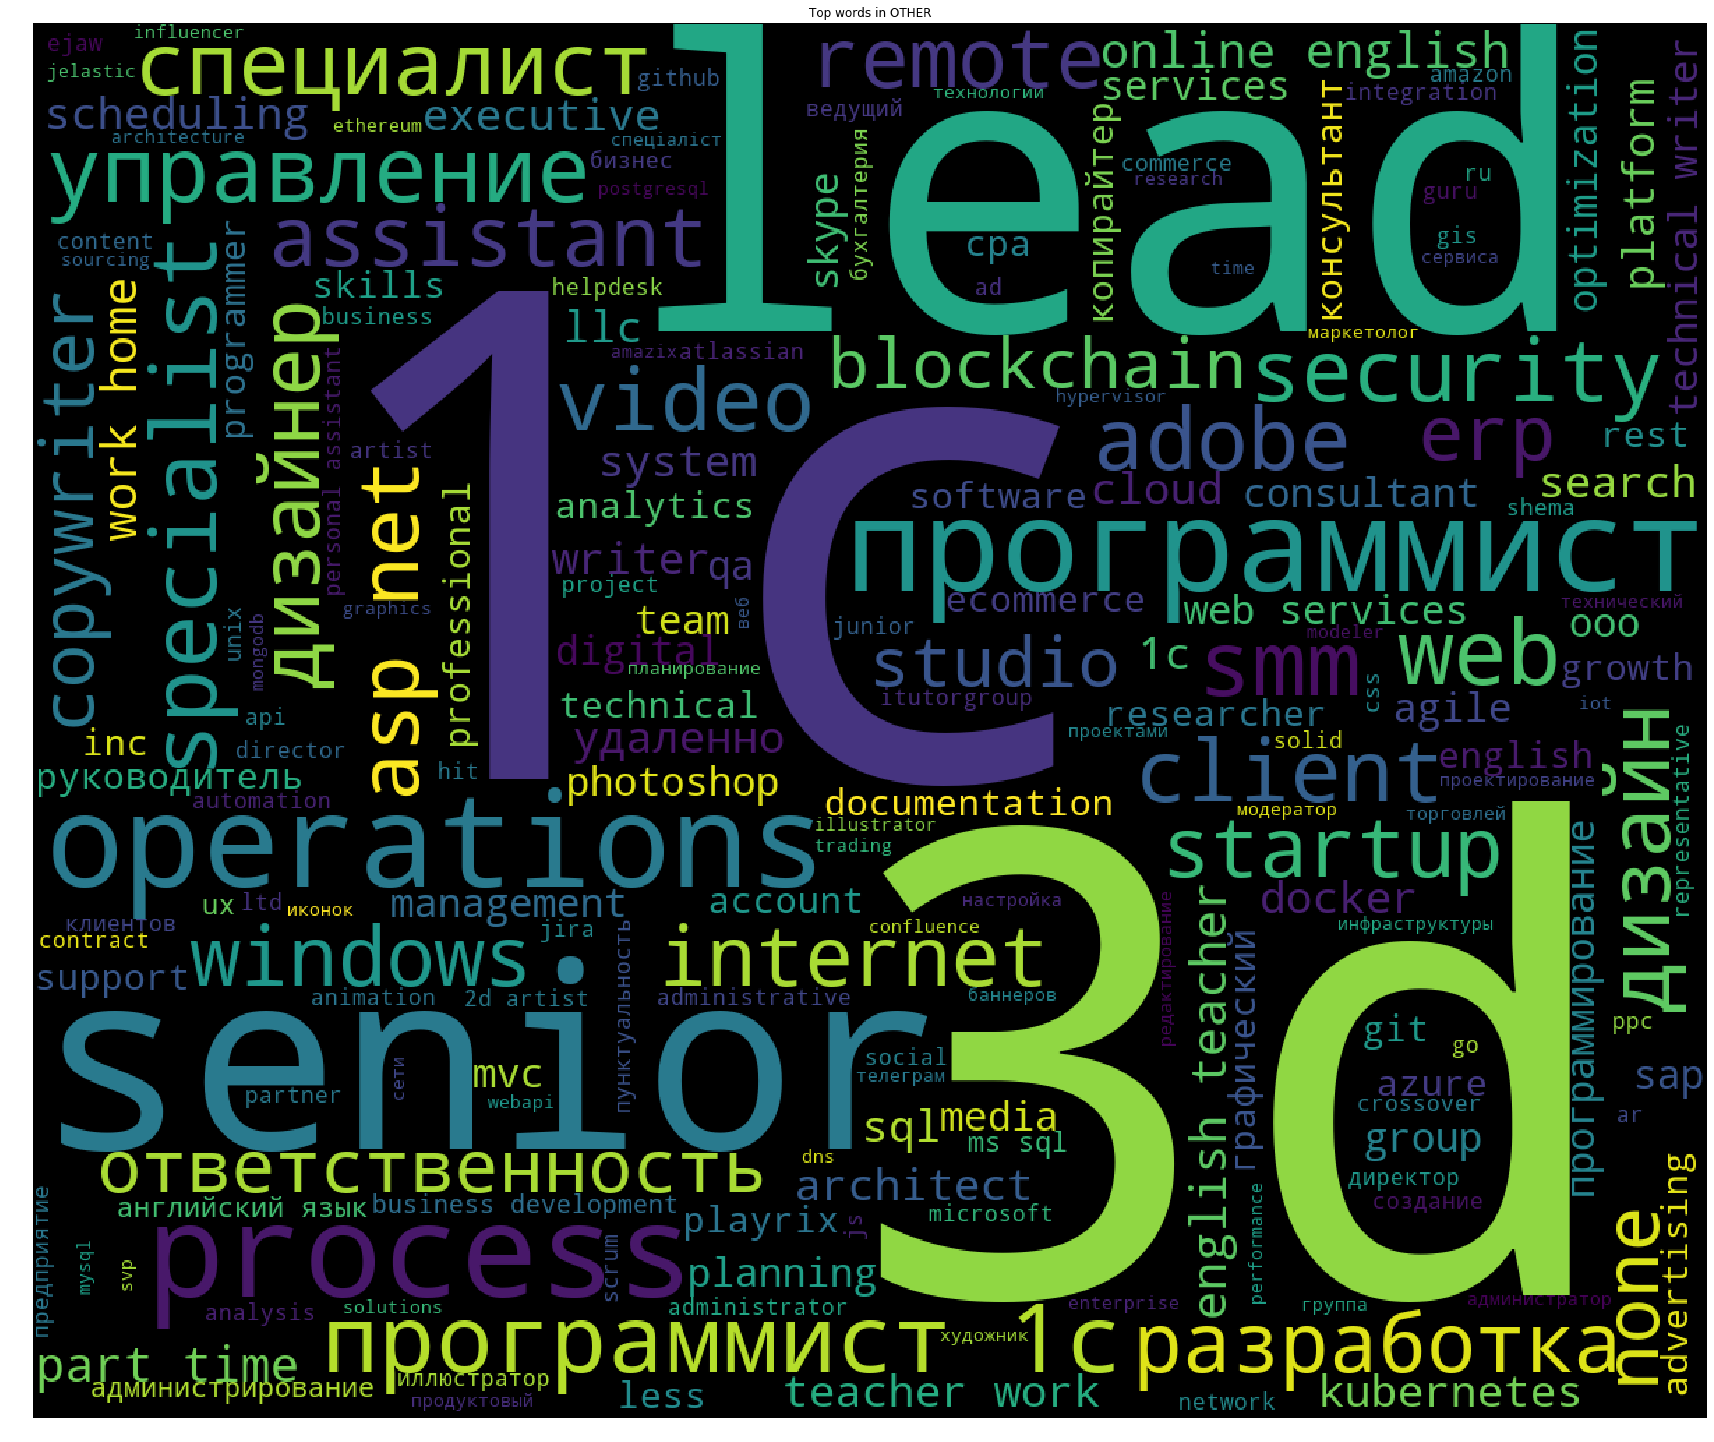

In [13]:
text = ' '.join(tt)
wordcloud = WordCloud(max_font_size=None, background_color='black',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(30, 30))
plt.imshow(wordcloud)
plt.title('Top words in OTHER')
plt.axis("off")
plt.show()

In [14]:
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from collections import defaultdict

In [15]:
def plot_top_ngrams(text,ngrams=(1,1),top=10,max_features=100,color='rgba(0,255,255,0.5)'):
    cv=CountVectorizer(ngram_range=ngrams,max_features=max_features)
    trans_text=cv.fit_transform(text)
    col_sum=trans_text.sum(axis=0)
    word_index=[(word,col_sum[0,idx]) for word,idx in cv.vocabulary_.items()]
    sorted_word_index=sorted(word_index,key=lambda x:x[1],reverse=True)
    top_words_index=sorted_word_index[:top]
    top_words=[element[0] for element in top_words_index]
    counts=[element[1] for element in top_words_index]
    df = pd.DataFrame(zip(top_words,counts))
    df.columns = ['top_words', 'counts']
    df.set_index('top_words', inplace=True)
    df.sort_values('counts', ascending=False)
    df.plot(y='counts', kind='bar', legend=False)

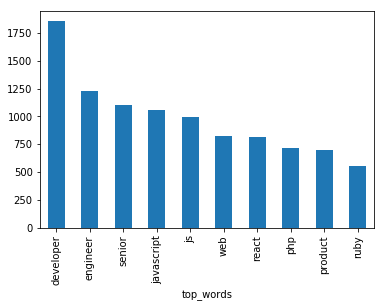

In [16]:
plot_top_ngrams(data.mes_description,ngrams=(1,1),top=10,color='rgba(128,0,0,0.5)')

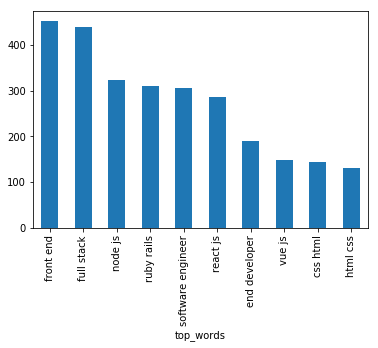

In [17]:
plot_top_ngrams(data.mes_description,ngrams=(2,2),top=10)

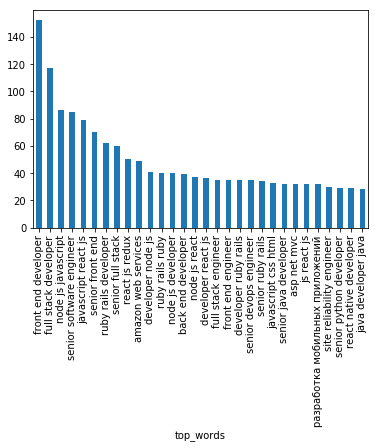

In [18]:
plot_top_ngrams(data.mes_description,ngrams=(3,3),top=30,color='rgba(128,128,128,0.5)')

In [21]:
X = data['mes_description']
Y = data['target']

train_X , val_X, train_y, val_y = train_test_split(X, Y, test_size=0.2, random_state=42)

In [22]:
print(train_X.shape)
print(val_X.shape)
print(train_y.shape)
print(val_y.shape)

(4390,)
(1098,)
(4390,)
(1098,)


In [23]:
cv=CountVectorizer(ngram_range=(1,2), analyzer='word')
train_X_cv=cv.fit_transform(train_X.values)
val_X_cv=cv.transform(val_X.values)

In [24]:
tsvd = TruncatedSVD(n_components=50, random_state=42)
train_X_svd = tsvd.fit_transform(train_X_cv)
val_X_svd = tsvd.transform(val_X_cv)
tsne = TSNE(n_components=2, random_state=42)
train_X_tsne = tsne.fit_transform(train_X_svd)

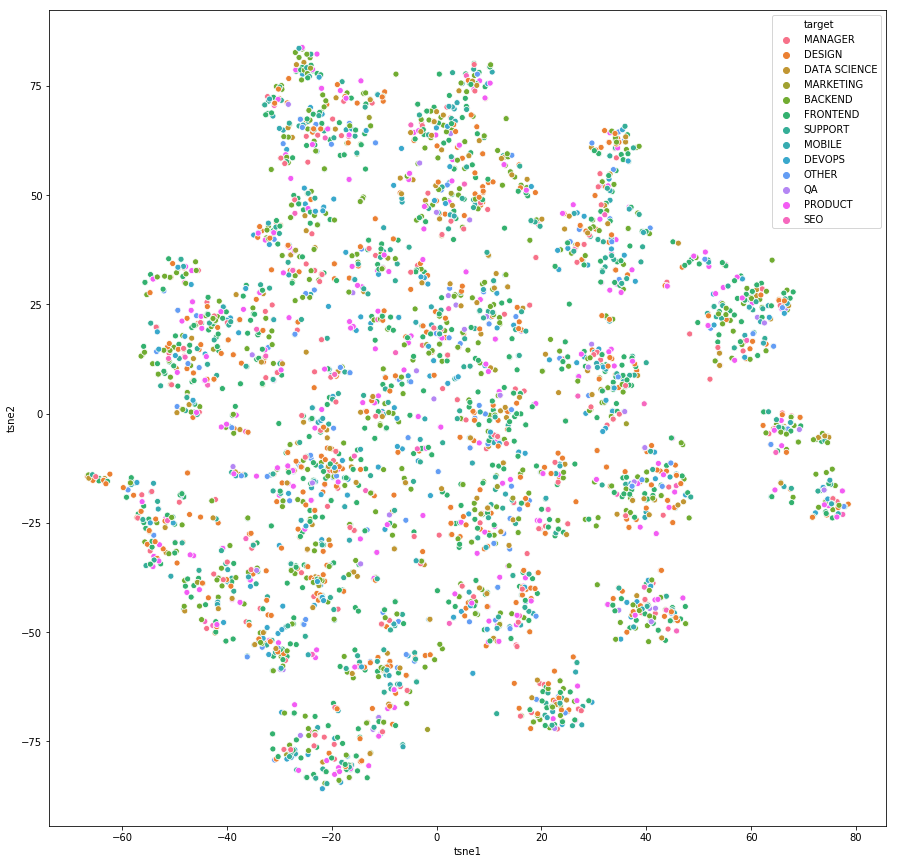

In [25]:
df = pd.DataFrame()
df["tsne1"] = pd.Series(train_X_tsne[:, 0])
df["tsne2"] = pd.Series(train_X_tsne[:, 1])
df["target"] = train_y
plt.figure(figsize=(15, 15))
sns.scatterplot(
    df["tsne1"], df["tsne2"], hue="target", data=df
)
plt.show()

In [36]:
type(train_y.unique())

numpy.ndarray

In [37]:
label = train_y.unique().tolist()

In [46]:
def get_model(model, train_X, train_y, val_X):
    model.fit(train_X, train_y)
    pred_probs = model.predict_proba(val_X)
    pred_train = model.predict(train_X)
    pred_val = model.predict(val_X)
    score_train = f1_score(train_y, pred_train, average=None)
    score_val = f1_score(val_y, pred_val, average=None)
    return (
        pred_probs,
        pred_train,
        pred_val,
        score_train,
        score_val,
    )


def get_confusion_matrix(val_y, pred, title):
    cm = confusion_matrix(val_y, pred, labels=label)
    #plt.figure(figsize=(15, 15))
    #sns.heatmap(cm, annot=True)
    #plt.title(title)
    #plt.ylabel("True labels")
    #plt.xlabel("Predicted labels")
    #plt.show()
    fig = plt.figure(figsize=(15, 15))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix' + title); 
    ax.xaxis.set_ticklabels(label);
    ax.yaxis.set_ticklabels(label);


def get_roc_curve(val_y, pred_probs, title):
    #plt.figure(figsize=(15, 15))
    plt.title(title)
    skplt.metrics.plot_roc(val_y, pred_probs, figsize=(15, 15))

In [27]:
models = [
    LogisticRegression(random_state=42),
    MultinomialNB(),
    DecisionTreeClassifier(random_state=42),
    AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=3),
        n_estimators=100,
        learning_rate=0.1,
        random_state=42,
    ),
    RandomForestClassifier(
        n_estimators=100, max_depth=3, random_state=42
    ),
    XGBClassifier(random_state=42),
]
model_names = [
    "LR",
    "Multinomial NB",
    "DTC",
    "ABC",
    "RFC",
    "XGBC",
]

In [28]:
pred_probs = {}
pred_train = {}
pred_val = {}
score_train = {}
score_val = {}

for i in range(len(models)):
    pred_probs[model_names[i]], pred_train[
        model_names[i]
    ], pred_val[model_names[i]], score_train[
        model_names[i]
    ], score_val[
        model_names[i]
    ] = get_model(
        models[i], train_X_cv, train_y, val_X_cv
    )


scl = StandardScaler()
train_X_scl_cv = scl.fit_transform(train_X_svd)
val_X_scl_cv = scl.transform(val_X_svd)
pred_probs["SVC"], pred_train["SVC"], pred_val[
    "SVC"
], score_train["SVC"], score_val["SVC"] = get_model(
    SVC(probability=True, random_state=42),
    train_X_scl_cv,
    train_y,
    val_X_scl_cv,
)

/home/renat/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/home/renat/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/home/renat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

/home/renat/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



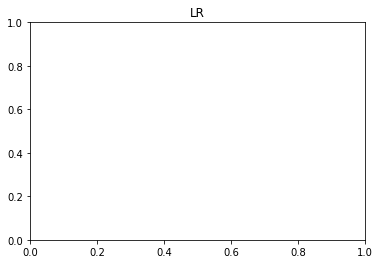

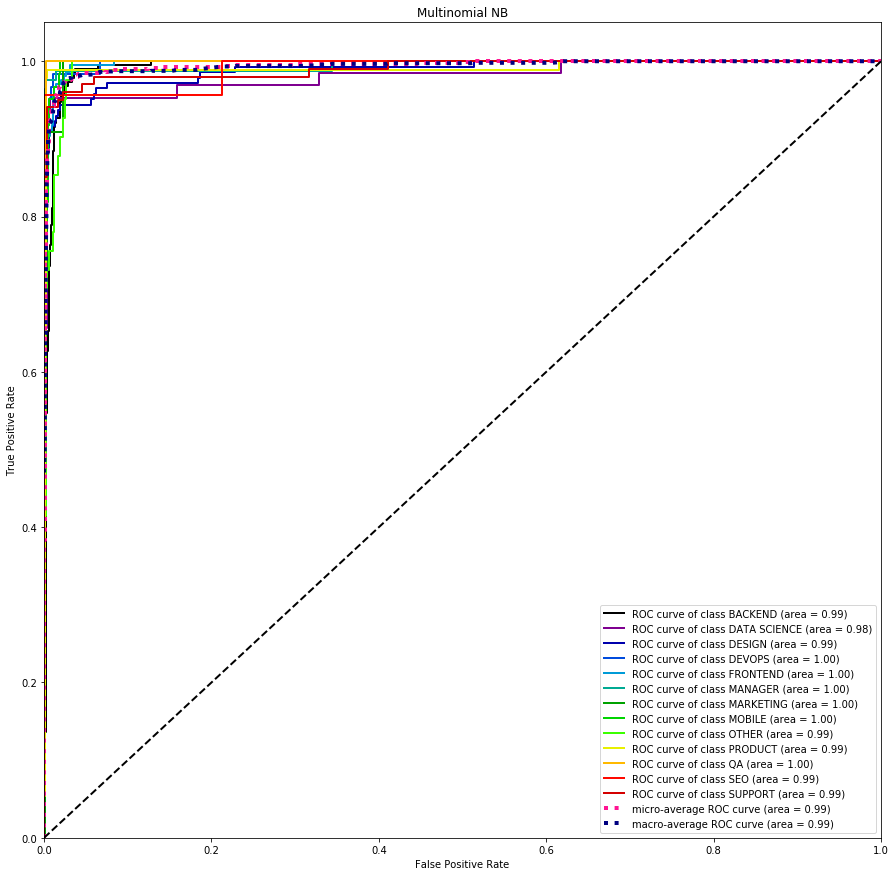

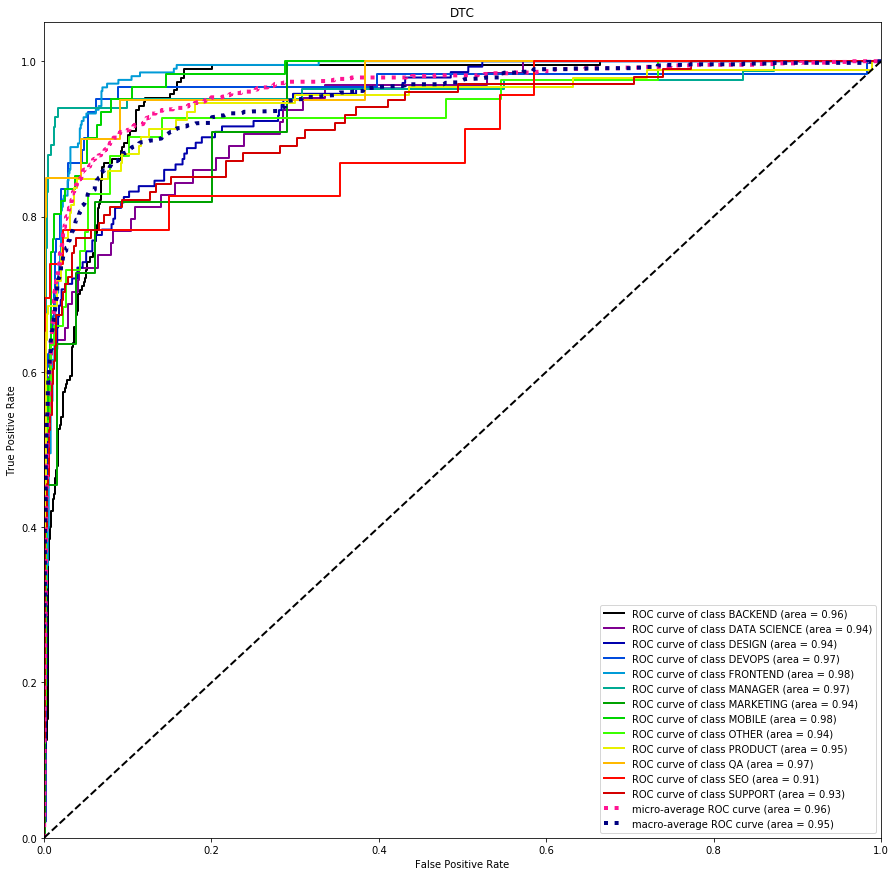

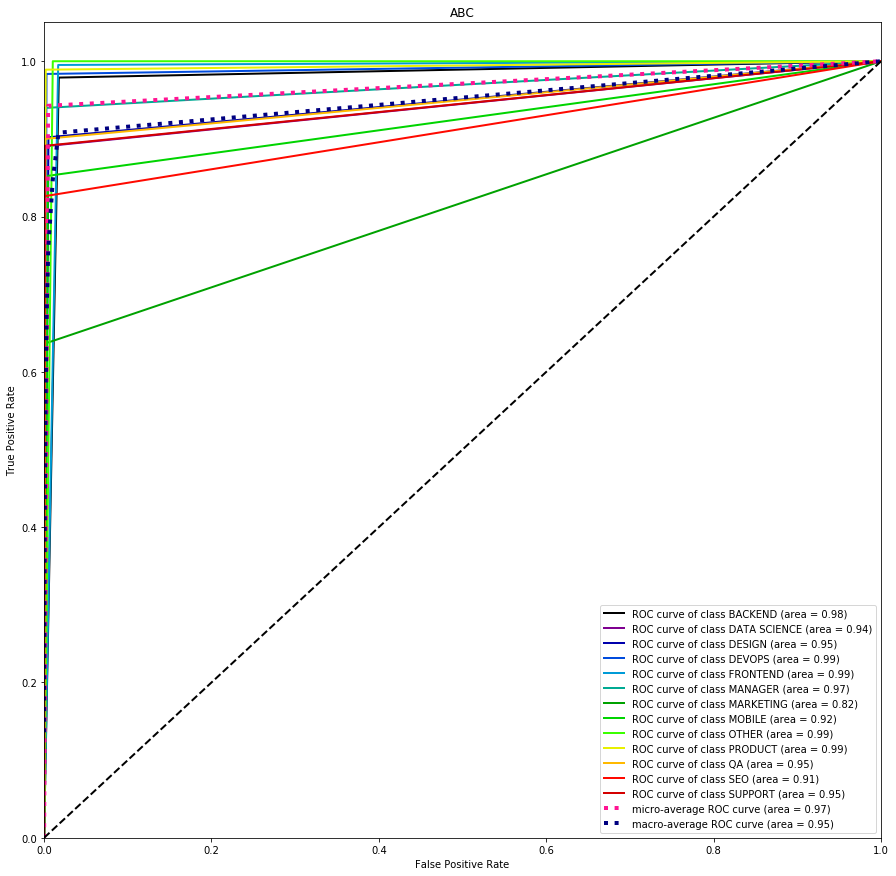

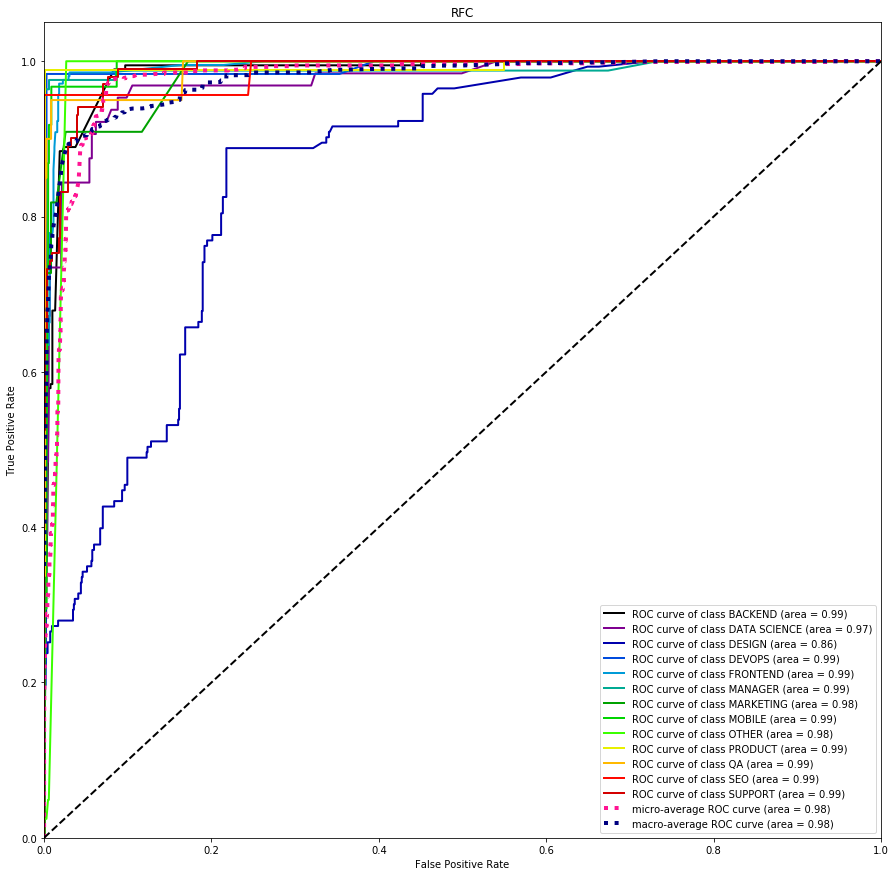

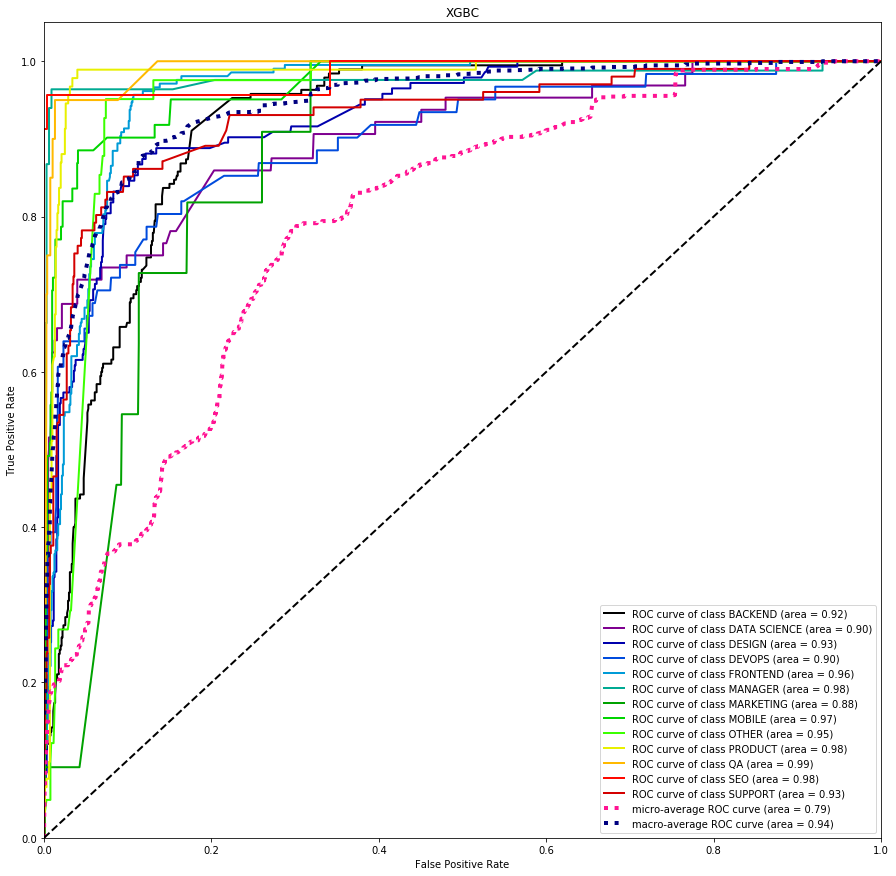

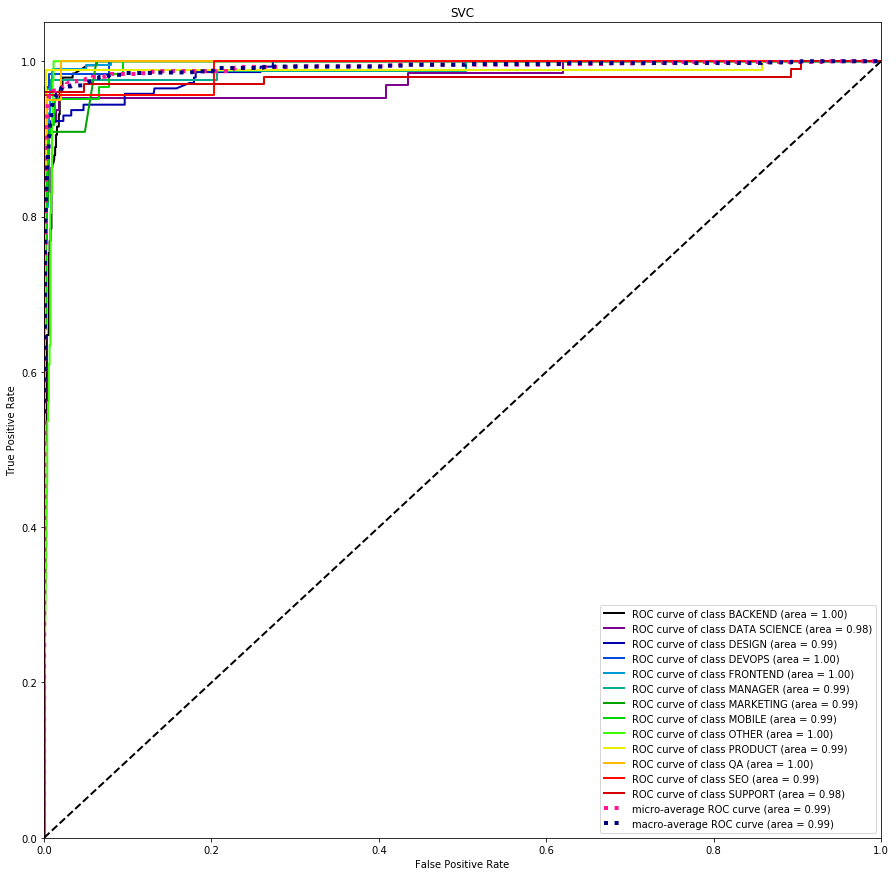

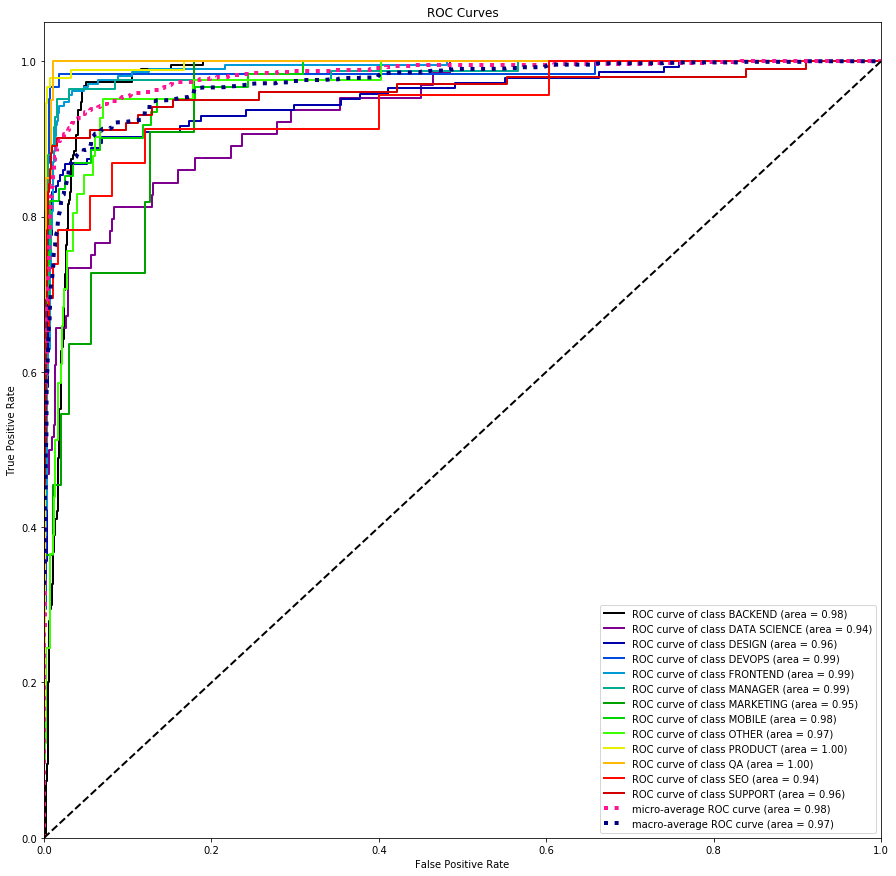

In [29]:
for model,probs in pred_probs.items():
    get_roc_curve(val_y,probs,model)

['SUPPORT', 'BACKEND', 'PRODUCT', 'DEVOPS', 'FRONTEND', 'MANAGER', 'MOBILE', 'DESIGN', 'SEO', 'DATA SCIENCE', 'MARKETING', 'OTHER', 'QA']
['SUPPORT', 'BACKEND', 'PRODUCT', 'DEVOPS', 'FRONTEND', 'MANAGER', 'MOBILE', 'DESIGN', 'SEO', 'DATA SCIENCE', 'MARKETING', 'OTHER', 'QA']
['SUPPORT', 'BACKEND', 'PRODUCT', 'DEVOPS', 'FRONTEND', 'MANAGER', 'MOBILE', 'DESIGN', 'SEO', 'DATA SCIENCE', 'MARKETING', 'OTHER', 'QA']
['SUPPORT', 'BACKEND', 'PRODUCT', 'DEVOPS', 'FRONTEND', 'MANAGER', 'MOBILE', 'DESIGN', 'SEO', 'DATA SCIENCE', 'MARKETING', 'OTHER', 'QA']
['SUPPORT', 'BACKEND', 'PRODUCT', 'DEVOPS', 'FRONTEND', 'MANAGER', 'MOBILE', 'DESIGN', 'SEO', 'DATA SCIENCE', 'MARKETING', 'OTHER', 'QA']
['SUPPORT', 'BACKEND', 'PRODUCT', 'DEVOPS', 'FRONTEND', 'MANAGER', 'MOBILE', 'DESIGN', 'SEO', 'DATA SCIENCE', 'MARKETING', 'OTHER', 'QA']
['SUPPORT', 'BACKEND', 'PRODUCT', 'DEVOPS', 'FRONTEND', 'MANAGER', 'MOBILE', 'DESIGN', 'SEO', 'DATA SCIENCE', 'MARKETING', 'OTHER', 'QA']


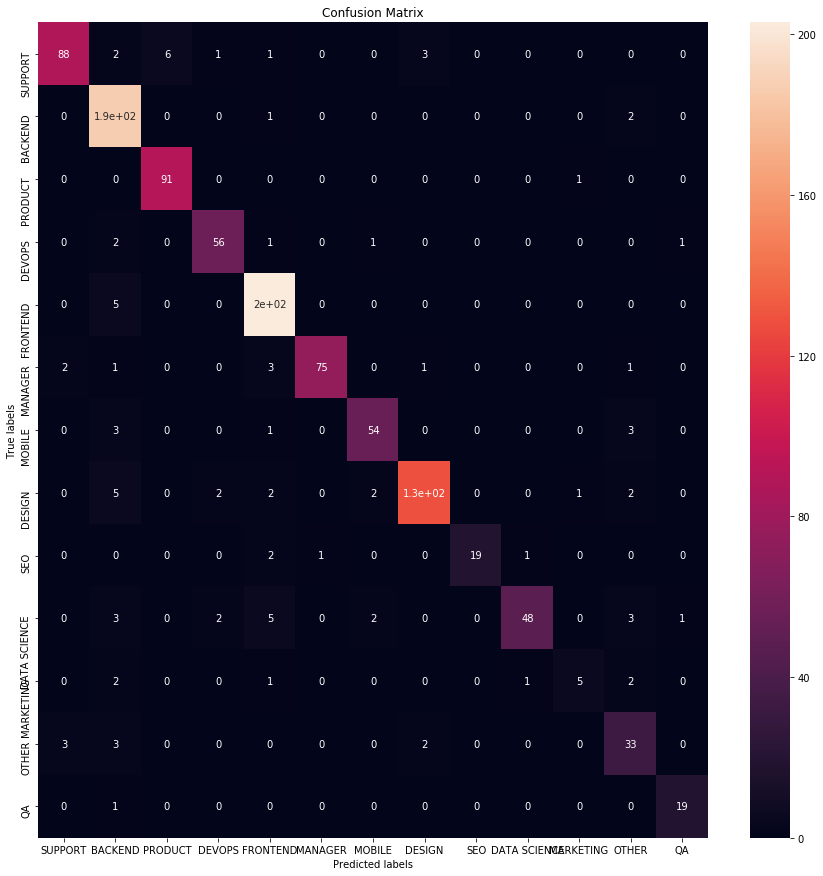

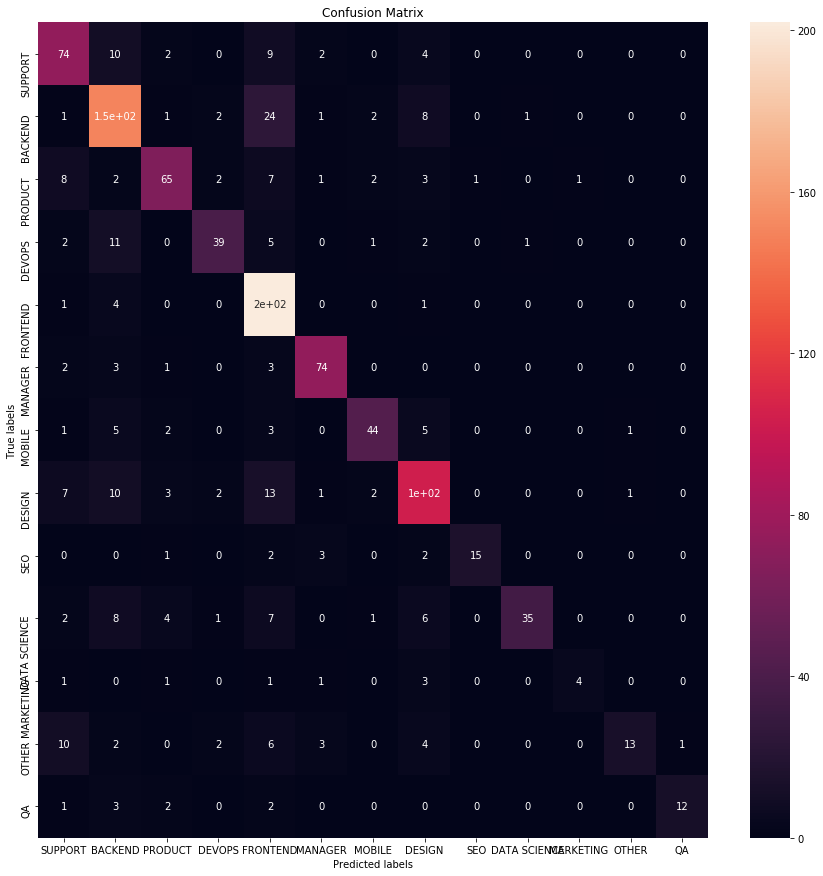

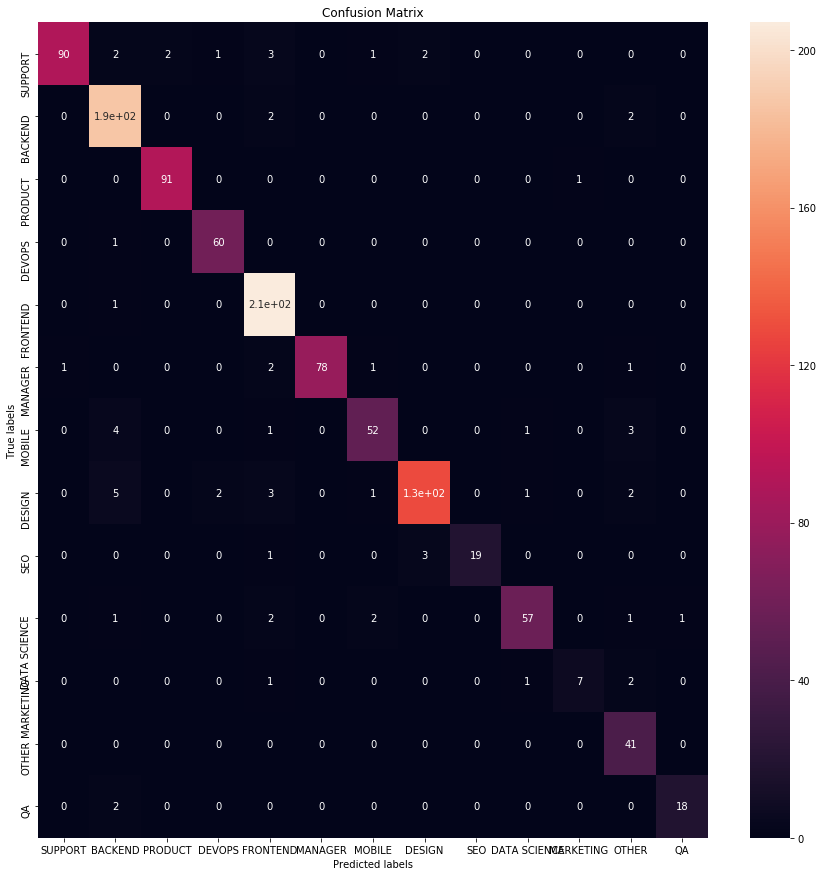

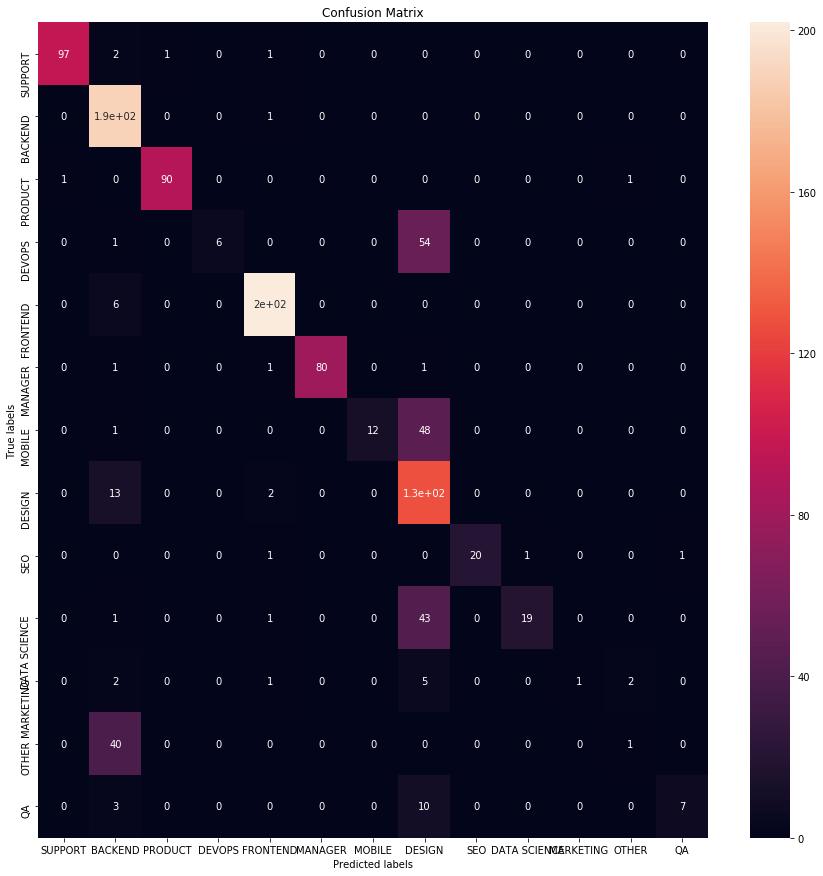

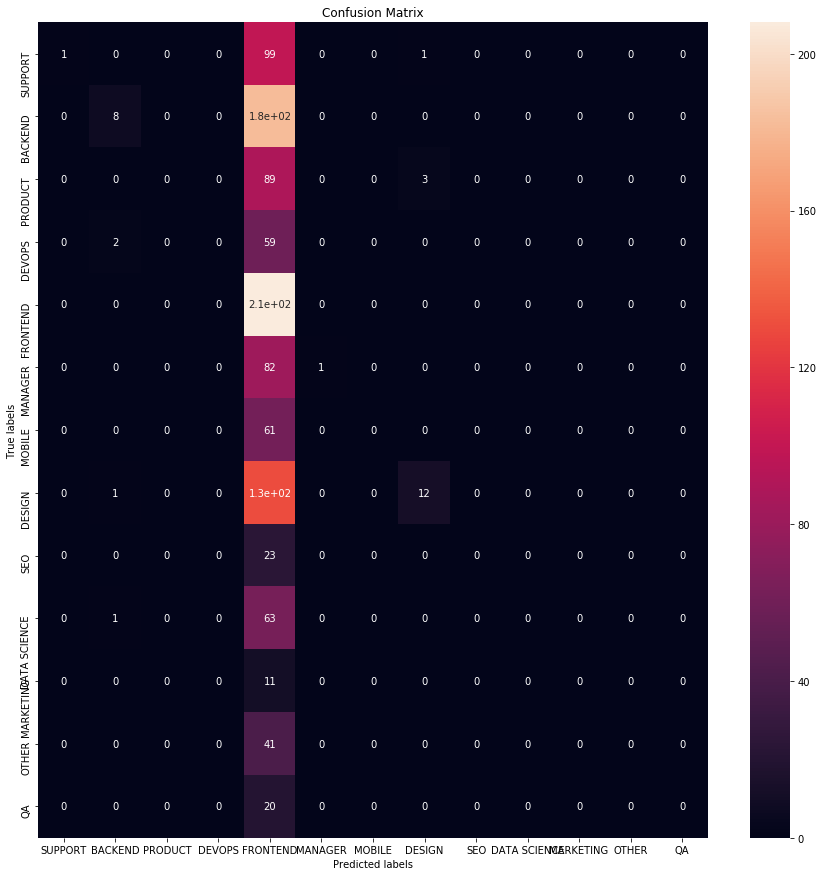

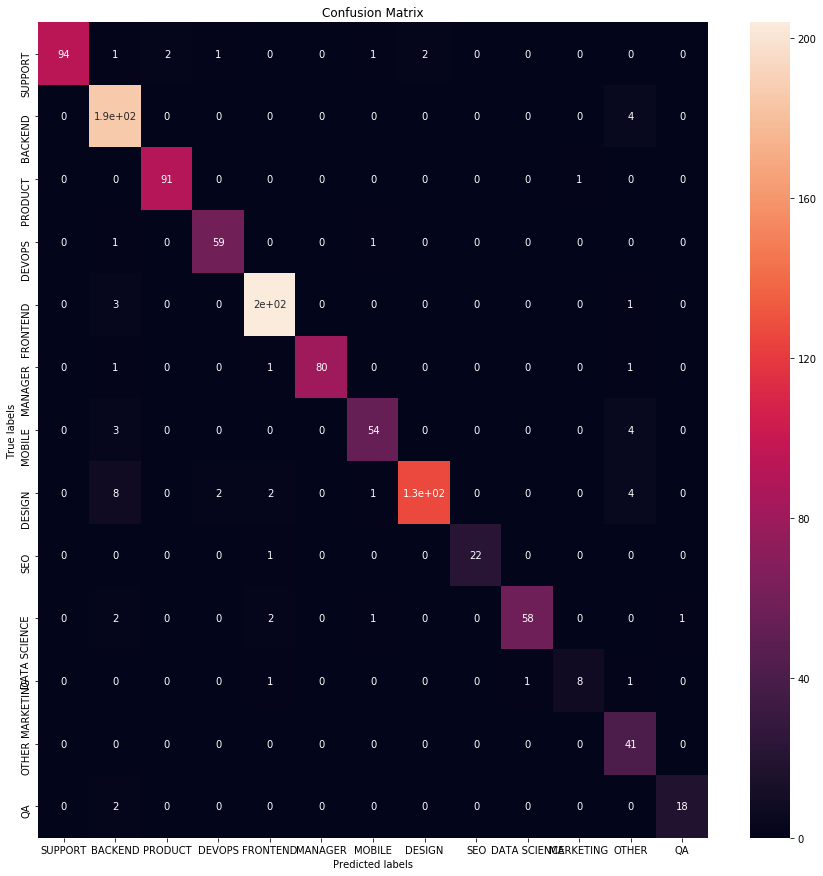

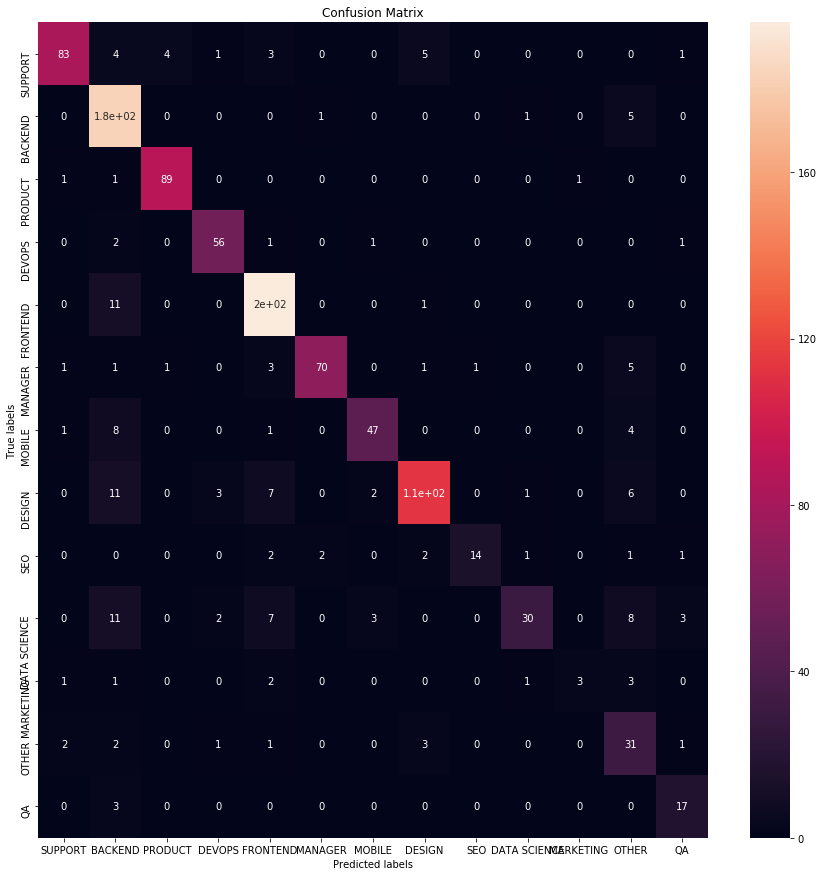

In [47]:
for model,pred in pred_val.items():
    get_confusion_matrix(val_y,pred,model)